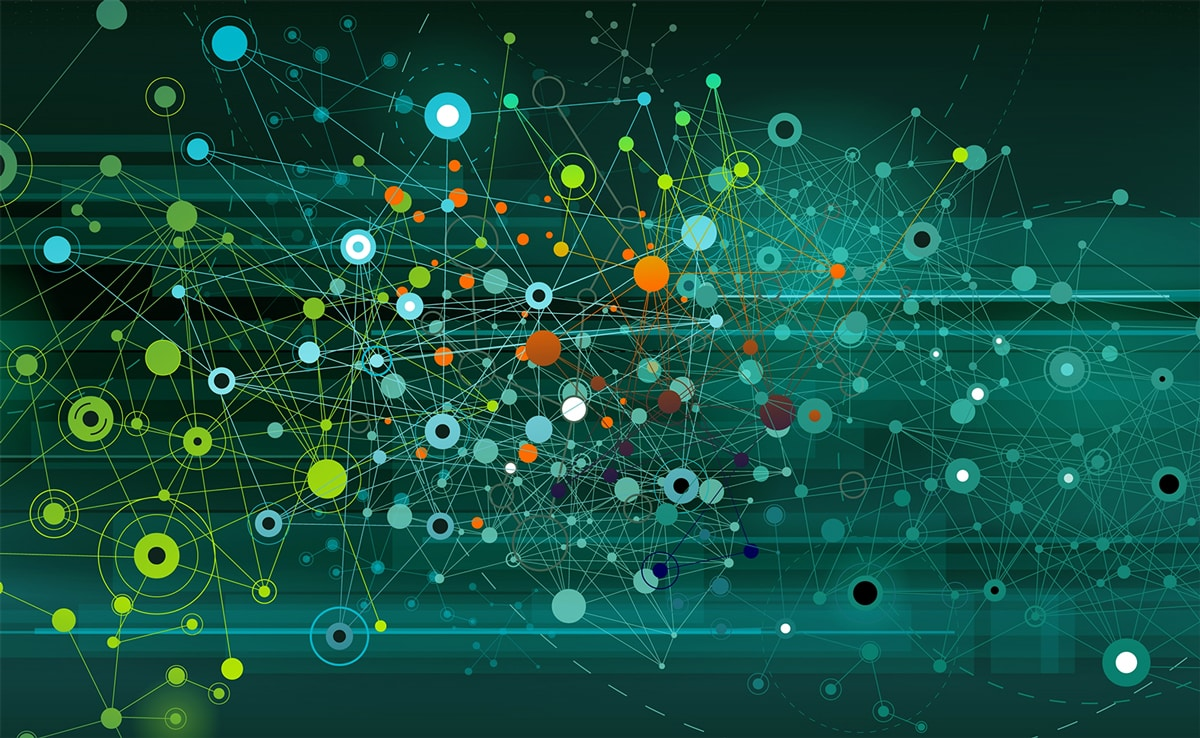
# Livrable 1

## Classification binaire

### Groupe de projet :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>

### Introduction

Dans un premier temps, ce premier livrable consiste en la réalisation d'un classificateur binaire. Ce classificateur à pour role de séparé les datasets fournis en deux groupe, un groupe "photo" et un groupe "pas photo" :
- Photo
- Painting
- Schematics
- Sketch
- Texte



## Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import configuration
import fidle.pwk as pwk
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import pathlib
from tensorboard.plugins.hparams import api as hp
%matplotlib inline

## Datasets

Pour 

In [2]:
image_h = 180
image_w = 180
batch_s = 32

data_dir = configuration.data_dir
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.8, 
  subset = "training",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

# Le test_set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)
class_names = train_set.class_names


Found 41405 files belonging to 2 classes.
Using 8281 files for training.
Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


## Visualisation

Dans un second temps nous allons voir la répartion des dataset, en effet les dataset ne sont surement pas équilibré, pour cela nous allons utiliser un histogramme, cette histogramme vas nous permettre de mettre cela en évidence pour chaque classe.

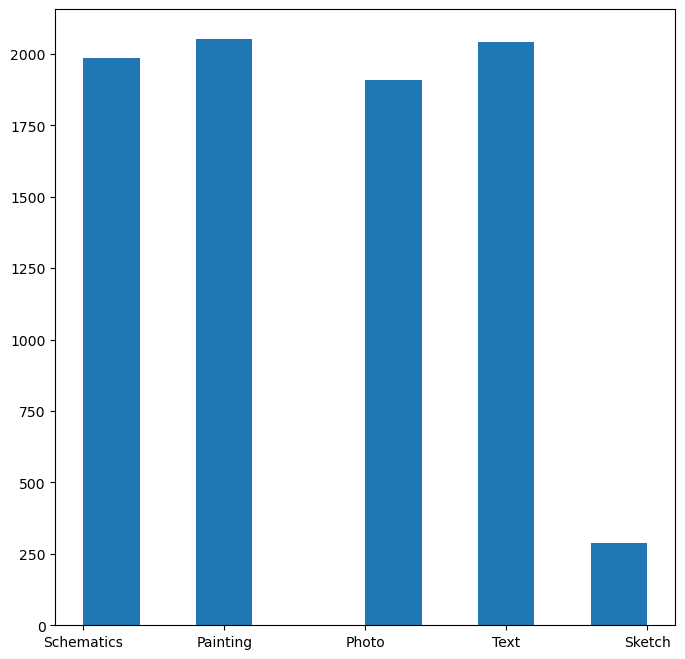

Nous voyons donc que les jeux de données ne sont pas équilibré, cela risquerait de donner un bies dans le model.
Pour cela nous verrons par la suite comment nous avons remedier à ce problème.


Par la suite nous avons aussi décider d'afficher différentes images de chaque classe, de façon à avoir une représentation de chaque classe.

In [3]:
# Répartition des classes

# label_list = []
# i=0
# plt.figure(figsize=(8, 8))
# for images, labels in train_set.take(-1):
#     i += 1
#     print(i)
# for label in labels.numpy():
#     label_list.append(class_names[label])
# for i in range(9):
#     ax =  plt.subplot(3, 3, i + 1)
#     plt.title(class_names[labels[i]])
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.axis("off")

# plt.hist(label_list)
# plt.show()


### Batch info

Le image_batch est un tenseur de la forme (256, 180, 180, 3) . Ceci est un lot de 256 images de forme 180x180x3 (la dernière dimension se réfère à des canaux de couleur RVB). 

Le label_batch est un tenseur de la forme (256,) , ceux - ci sont des étiquettes correspondant aux 256 images.

In [4]:
for image_batch, labels_batch in train_set:
   print(image_batch.shape)
   print(labels_batch.shape)
   break


(32, 180, 180, 3)
(32,)


## Mise en cache

In [5]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
#
# train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

### Trier l'image en noir et blanc

Pour réduire le nombre d'images dans le dataset notre équipe à procédé à l'extraction des images binaire.
En effet l'ensemble de texte étant uniquement binaire, ceci permet de réduire notre jeu de données.

In [6]:
def removeBlackAndWhite():
    for image in data_dir:
        print()
        with Image.open(image) as im:
            colors = im.getcolors()
            print(colors)
        # if que du noir, remove l'image
    


## Construction du modèle 1 couche de convolution
Pour réaliser ce modèle nous avons créé une architecture reposant sur plusieurs couches :

- Une layers Rescaling :
- Une layers Conv2D :
- Une layers MaxPooling2D :
- Une layers Dropout :
- Une layers Flatten :
- Une layers Dense :
- Une layers Dense :


In [7]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(image_h,
                                  image_w,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

# Le modèle
model_single_layer = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])
# Compilation du modèle
model_single_layer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
})
# Résumé du modèle
model_single_layer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                      

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [8]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_single_layer_{epoch:02d}-{val_accuracy:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max')

### Entrainement du modèle

In [9]:
if not os.path.isfile('./training/simple_layer_model.5.h5'):
    epochs=3
    history = model_single_layer.fit(
      train_set,
      validation_data=validation_set,
      epochs=epochs,
      callbacks=[cp_callback]
    )

    # Save the model
    save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+"-"+str(history.history['val_accuracy'][-1])+".ckpt"
    model_single_layer.save_weights(save_path)
    model_single_layer.save_weights('./training/simple_layer_model.5.h5')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


## Construction du modèle 3 couche de convolution

In [10]:
def construct_model(conv_nb = 16, dropout = 0.2, last_layer_nb = 32, optimizer='adam'):
    num_classes_l = len(class_names)
    data_augmentation_l = keras.Sequential(
      [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                          input_shape=(image_h,
                                      image_w,
                                      3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
      ]
    )
    model_name = "conv_nb_"+str(conv_nb)+"-dropout_"+str(dropout)+"-last_layer_nb_"+str(last_layer_nb)+"-optimizer_"+optimizer
    # Le modèle
    model_multiple_layers_l = Sequential([
      data_augmentation_l,
      layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
      layers.Conv2D(conv_nb, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(conv_nb * 2, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(conv_nb * 4, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout),
      layers.Flatten(),
      layers.Dense(last_layer_nb, activation='relu'),
      layers.Dense(num_classes_l)
    ], model_name)
    # Compilation du modèle
    model_multiple_layers_l.compile(optimizer= optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(
    #     log_dir=log_dir, histogram_freq=1)
    # hparams_callback = hp.KerasCallback(log_dir, {
    #     'num_relu_units': 16,
    #     'dropout': 0.2
    # } )
    # Résumé du modèle
    model_multiple_layers_l.summary()
    return model_multiple_layers_l

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [11]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_multiple_layers_{epoch:02d}-{val_accuracy:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max')

### Entrainement du modèle

In [12]:
def run_model(model, epochs = 3, isMultiple = False):
    if not os.path.isfile('./training/mulitple_layer_model.5.h5') or isMultiple:
        # Entrainement du modèle
        history = model.fit(
          train_set,
          validation_data=validation_set,
          epochs=epochs,
        )
        # callbacks=[cp_callback]
        return history
        # model.save_weights('./training/mulitple_layer_model.5.h5')

        # acc = history.history['accuracy']
        # val_acc = history.history['val_accuracy']
        #
        # loss = history.history['loss']
        # val_loss = history.history['val_loss']
        #
        # epochs_range = range(epochs)
        #
        # plt.figure(figsize=(16, 8))
        # plt.subplot(1, 2, 1)
        # plt.plot(epochs_range, acc, label='Training Accuracy')
        # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        # plt.legend(loc='lower right')
        # plt.title('Training and Validation Accuracy')
        #
        # plt.subplot(1, 2, 2)
        # plt.plot(epochs_range, loss, label='Training Loss')
        # plt.plot(epochs_range, val_loss, label='Validation Loss')
        # plt.legend(loc='upper right')
        # plt.title('Training and Validation Loss')
        # plt.show()

In [13]:
# !tensorboard dev upload --logdir ./logs \
#   --name "Attempt 2" \
#   --description "Add 2 layer with convolution (32, 64) + max pooling" \
#   --one_shot

## Tests de plusieurs modèles

In [14]:
epochs_list = [5, 10, 15]
conv_nb_list = [8, 16]
dropout_list = [0.0, 0.2]
last_layer_nb_list = [32, 64]
optimizer_list =['adam']

for epochs in epochs_list:
    for conv_nb in conv_nb_list:
        for dropout in dropout_list:
            for last_layer_nb in last_layer_nb_list:
                for optimizer in optimizer_list :
                    model = construct_model(conv_nb, dropout, last_layer_nb, optimizer)
                    history = run_model(model, epochs, True)
                    # Save the model
                    save_path = "multiple_tests_saves/epochs="+str(epochs)+"-conv_nb="+str(conv_nb)+"-dropout="+str(dropout)+"-last_layer_nb="+str(last_layer_nb)+"-optimizer="+optimizer+"-accuracy="+str(history.history['val_accuracy'][-1])+".h5"
                    model.save_weights(save_path)

# model = construct_model()
# history = run_model(model, 5, True)
# model.save_weights('./training/mulitple_layer_model_other.h5')

Model: "conv_nb_16-dropout_0.2-last_layer_nb_32-optimizer_adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)        

## Validation

### Recupération du model

In [17]:
model_multiple_layers = construct_model()
# model_multiple_layers.load_weights("./training/mulitple_layer_model.5.h5")
model_multiple_layers.load_weights("./training/mulitple_layer_model_other.h5")


Model: "conv_nb_16-dropout_0.2-last_layer_nb_32-optimizer_adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)        

## Test de l'accuracy du model

In [18]:
test_loss, test_acc = model_multiple_layers.evaluate(validation_set, verbose=2)

print('\nTest accuracy:', test_acc)

# y_sigmoid = model_multiple_layers.predict(validation_set)
# y_pred    = np.argmax(y_sigmoid, axis=-1)

259/259 - 38s - loss: 0.2723 - accuracy: 0.8731 - 38s/epoch - 145ms/step

Test accuracy: 0.8730829358100891


### Matrice de confusion

In [19]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
list_image = []
list_pred = []

# iterate over the dataset
for image_batch, label_batch in validation_set:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_multiple_layers.predict(image_batch)
   list_pred.append(preds)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
   list_image.append(image_batch)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

Confusion Matrix
[[5608  732]
 [ 319 1622]]


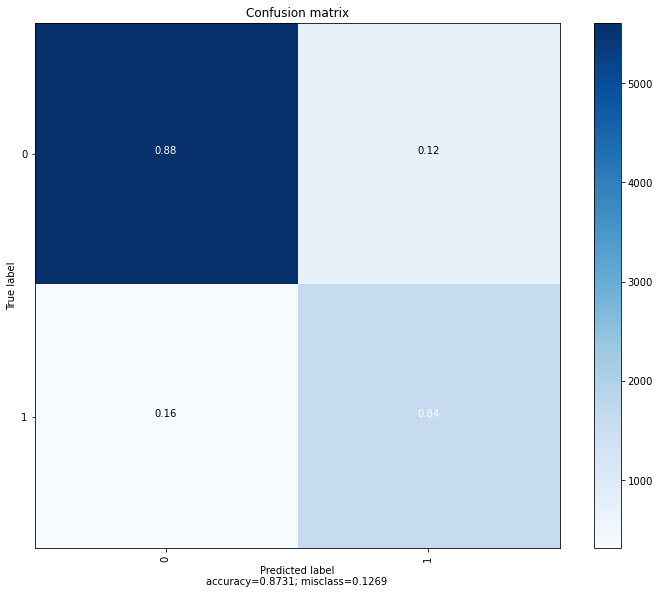

In [24]:

print('Confusion Matrix')
print(confusion_matrix(correct_labels, predicted_labels))
pwk.plot_confusion_matrix(correct_labels,predicted_labels,range(num_classes),normalize=True, save_as='06-confusion-matrix')

In [21]:
print('Classification Report')

print(classification_report(correct_labels, predicted_labels, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       Other       0.95      0.88      0.91      6340
       Photo       0.69      0.84      0.76      1941

    accuracy                           0.87      8281
   macro avg       0.82      0.86      0.83      8281
weighted avg       0.89      0.87      0.88      8281



## Exemple d'erreurs

In [22]:
# file_paths = validation_set.file_paths


<ipython-input-25-5098b88019d3>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, j + 1)


IndexError: index 25 is out of bounds for axis 0 with size 25

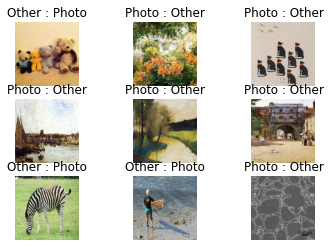

In [25]:

batch_iterator = 0
for images, labels in validation_set.take(500, 'aa'):

    preds = model_multiple_layers.predict(images)
    preds = np.argmax(preds, axis = - 1)
    j = 0
    b = 0
    while j < 9 and b < batch_s:
        if preds[b] != labels[b].numpy():
            ax = plt.subplot(3, 3, j + 1)
            j += 1
            # print(validation_set.take(batch_iterator).file_paths[i])
            plt.imshow(images[b].numpy().astype("uint8"))
            plt.title(class_names[preds[b]] + " : " + class_names[labels[b].numpy()])
            plt.axis("off")
        b += 1
    batch_iterator += 1
plt.tight_layout()
plt.show()
